# Download Apple Watch data

This template provides example code for accessing and saving Apple Watch data. This includes accelerometry, rotation, and probability scores for tremor and dyskinesia.

In [1]:
import io
import pandas as pd
import matplotlib.pyplot as plt
from runeq import Config, stream

## Functions for pulling raw accelerometry, raw rotation, dyskinesia probability, and tremor probability

In [2]:
def make_full_df(accessor):
    '''Loop through pages of API calls and append to a single dataframe'''
    
    df = pd.DataFrame()
    for page in accessor.iter_csv_text():
        page_df = pd.read_csv(io.StringIO(page))
        df = df.append(page_df, ignore_index=True)

    return df

def get_accel(client, params, save_filepath):
    '''Makes API calls for accel data, saves to CSV and outputs dataframe'''

    accessor = client.Accel(**params)
    df = make_full_df(accessor)
    
    # save dataframe to a csv
    df.to_csv(save_filepath, index=False)
    
    return df

def get_rotation(client, params, save_filepath):
    '''Makes API calls for rotation data, saves to CSV and outputs dataframe'''

    accessor = client.Rotation(**params)
    df = make_full_df(accessor)
    
    # save dataframe to a csv
    df.to_csv(save_filepath, index=False)
    
    return df

def get_tremor(client, params, save_filepath):
    '''Makes API calls for tremor data, saves to CSV and outputs dataframe'''

    accessor = client.ProbabilitySymptom(symptom='tremor', severity='*', **params)
    df = make_full_df(accessor)
    
    # save dataframe to a csv
    df.to_csv(save_filepath, index=False)
    
    return df

def get_dyskinesia(client, params, save_filepath):
    '''Makes API calls for dyskinesia data, saves to CSV and outputs dataframe'''

    accessor = client.ProbabilitySymptom(symptom='dyskinesia', **params)
    df = make_full_df(accessor)
    
    # save dataframe to a csv
    df.to_csv(save_filepath, index=False)
    
    return df

## 1. Initialize API credentials

First initialize your API credentials. These credentials are analogous to having a username/password for accessing patient data. You will set up a 'client' to access data for each patient, and each client has its own ID and secret. 

- Navigate to the web app (https://app.runelabs.io/patients) as an **admin** user
- Click the pencil next to the patient of interest
- Open the 'Clients' section and create a new client. Copy the ID and secret (these will only be shown once)
- Open the 'Devices' section to find the device IDs.

Next, set up a .yaml file with your client ID and secret. This is text file that will store your credentials.  An example can be found here: https://github.com/rune-labs/runeq-python/blob/master/example_config.yaml.

We will load up this .yaml file to set up a client with the `runeq` package.

In [3]:
# set up client

cfg = Config('/Users/witney/Documents/api_config/dd_config.yaml')
client = stream.V1Client(cfg)

## 2. Specify endpoint parameters

In [4]:
params = {
    'device_id': 'applewatch',
    'start_time': 1588181820,
    'end_time': 1588202486,
    'timestamp': 'unix'
}

## 3. Retrieve accelerometry, rotation, tremor, and dyskinesia data

We will pass the client, our parameters, and a file path for saving our data into our functions above to obtain the CSV data. Be sure to change the file directories below. If you do not want to enter the full path every time, you could specify a base path, and then append the file name. For example:

```
import io

# set BASE_PATH to the folder where related files are stored / will be saved
BASE_PATH = '~/Documents/data_folder'

# expanduser allows us to use ~ as a shortcut for home
FULL_BASE_PATH = os.path.expanduser(BASE_PATH)

# full path to a specific file
os.path.join(FULL_BASE_PATH, 'name_of_data_file')
```

In [5]:
accel = get_accel(client, params, '/Users/witney/Documents/api_data/nb02_ex01_accel.csv')
rotation = get_rotation(client, params, '/Users/witney/Documents/api_data/nb02_ex01_rotation.csv')
tremor = get_tremor(client, params, '/Users/witney/Documents/api_data/nb02_ex01_tremor.csv')
dyskinesia = get_dyskinesia(client, params, '/Users/witney/Documents/api_data/nb02_ex01_dyskinesia.csv')

If loading CSV's:
```
accel = pd.read_csv('/Users/witney/Documents/api_data/nb02_ex01_accel.csv')
rotation = pd.read_csv('/Users/witney/Documents/api_data/nb02_ex01_rotation.csv')
tremor = pd.read_csv('/Users/witney/Documents/api_data/nb02_ex01_tremor.csv')
dyskinesia = pd.read_csv('/Users/witney/Documents/api_data/nb02_ex01_dyskinesia.csv')
```

## 4. Plot watch data

Text(0.5, 1.0, 'Dyskinesia Probability')

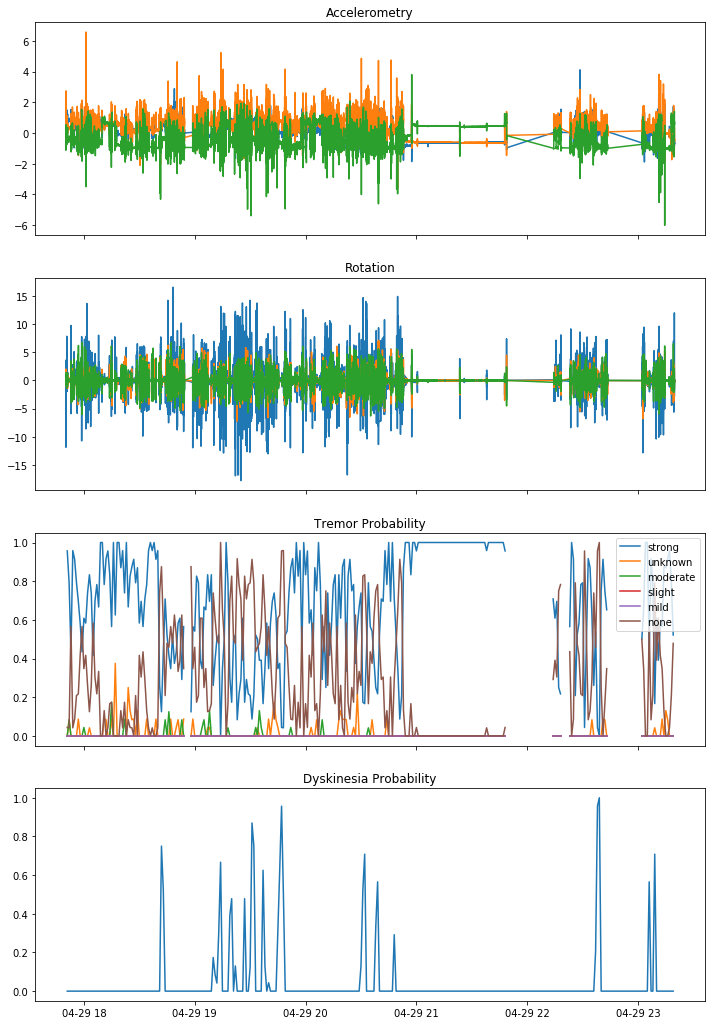

In [6]:
fig, ax = plt.subplots(4, figsize=(12,18), sharex=True)

ax[0].plot(pd.to_datetime(accel.time, unit='s'),accel.x)
ax[0].plot(pd.to_datetime(accel.time, unit='s'),accel.y)
ax[0].plot(pd.to_datetime(accel.time, unit='s'),accel.z)
ax[0].set_title('Accelerometry')

ax[1].plot(pd.to_datetime(rotation.time, unit='s'),rotation.x)
ax[1].plot(pd.to_datetime(rotation.time, unit='s'),rotation.y)
ax[1].plot(pd.to_datetime(rotation.time, unit='s'),rotation.z)
ax[1].set_title('Rotation')

ax[2].plot(pd.to_datetime(tremor.time, unit='s'),tremor.none)
ax[2].plot(pd.to_datetime(tremor.time, unit='s'),tremor.slight)
ax[2].plot(pd.to_datetime(tremor.time, unit='s'),tremor.mild)
ax[2].plot(pd.to_datetime(tremor.time, unit='s'),tremor.moderate)
ax[2].plot(pd.to_datetime(tremor.time, unit='s'),tremor.strong)
ax[2].plot(pd.to_datetime(tremor.time, unit='s'),tremor.unknown)
ax[2].set_title('Tremor Probability')
ax[2].legend({'none','slight','mild','moderate','strong','unknown'})

ax[3].plot(pd.to_datetime(dyskinesia.time, unit='s'),dyskinesia.probability)
ax[3].set_title('Dyskinesia Probability')

## 5. Filter watch data

With these dataframes, we can easily obtain the timestamps in which certain symptoms were present/absent.

In [7]:
# filter by dyskinesia probability
# ex. probability > 0.1
dyskinesia[dyskinesia.probability > 0.1]

# filter by tremor
# ex mild probability >0.1 or slight probability > 0.1
tremor[(tremor.mild > 0.1) | (tremor.slight> 0.1)]

,time,mild,moderate,none,slight,strong,unknown
38,1.588184e+09,0.173913,0.0,0.565217,0.086957,0.0,0.173913
40,1.588184e+09,0.000000,0.0,0.625000,0.375000,0.0,0.000000
47,1.588185e+09,0.000000,0.0,0.666667,0.250000,0.0,0.083333
48,1.588185e+09,0.000000,0.0,0.826087,0.130435,0.0,0.043478
52,1.588185e+09,0.000000,0.0,0.869565,0.130435,0.0,0.000000
69,1.588186e+09,0.125000,0.0,0.416667,0.000000,0.0,0.458333
91,1.588187e+09,0.130435,0.0,0.695652,0.043478,0.0,0.130435
118,1.588189e+09,0.130435,0.0,0.391304,0.000000,0.0,0.478261
126,1.588189e+09,0.000000,0.0,0.739130,0.173913,0.0,0.086957
162,1.588192e+09,0.000000,0.0,0.608696,0.130435,0.0,0.260870
